In [253]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import TwoSlopeNorm
from scipy import sparse

import netket as nk
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import json

### Generate Table of All Possible States Indexed in Lexigraphical Order

In [254]:
def generateStateTable(n,n0,N): # assumes ab > n0 > 0 and N = n choose n0
    states = []
    state = np.concatenate((np.ones(n-n0),-1*np.ones(n0))).astype(int)
    for i in range(0,N):
        states.append(np.copy(state))
        j = 0
        flag = True
        flip_count = 0
        up_count = 0
        while (flag): 
            if (j == n-1):
                for m in range(0,n):
                    if (state[m] != 1 and state[m+1] == 1):
                        flip_count += 1
                if (flip_count == 1):
                    break
            if (state[j] != 1):
                j += 1  
            elif (state[j+1] != 1):
                for m in range(0,j):
                    if (state[m] != 1 and state[m+1] == 1):
                        flip_count += 1
                    if (state[m] == 1):
                        up_count += 1
                if (flip_count == 1):
                    state[j],state[j+1] = state[j+1],state[j]
                    for k in range(1,up_count+1):
                        state[j-k],state[k-1] = state[k-1],state[j-k]
                else:
                    state[j],state[j+1] = state[j+1],state[j]
                flag = False
            else:
                j += 1
    return states

### Generate Adjacency Matrix

In [255]:
class Node:
    def __init__(self, position, adjacency):
        self.position = position
        self.adjacency = adjacency
    
    def __str__(self):
        return f"{self.position} {self.adjacency}"

In [256]:
def squareAdjacencyList(x1,x2,y1,y2): # constructs a non-periodic adjacency graph on a square lattice from (x1,y1) to (x2,y2)
    nodes = []
    
    for i in range(x1,x2+1):
        for j in range(y1,y2+1):
            adj = []
            if (i+1 <= x2):
                adj.append([i+1,j])
            if (i-1 >= x1):
                adj.append([i-1,j])
            if (j+1 <= y2):
                adj.append([i,j+1])
            if (j-1 >= y1):
                adj.append([i,j-1])
            nodes.append(Node([[i,j]],adj))

    return nodes

In [257]:
def solveLinearSystem(v1,v2,b): # returns x,y satisfying alpha*v1+beta*v2=b assuming v1 and v2 are linear independent
    A = np.transpose(np.array([v1,v2]))
    return np.dot(np.linalg.inv(A),b)

def coeffMatrix(v1,v2): # Z^2/([x,y]-[a,b],[x,y]-[c,d])
    a,b = v1
    c,d = v2

    # bounding box
    x1 = min(a,c,0) 
    x2 = max(a,c,0)
    y1 = min(b,d,0)
    y2 = max(b,d,0)
    nodes = squareAdjacencyList(x1,x2,y1,y2)

    # merge degenerate nodes
    for i in range(0,len(nodes)-1):
        for j in range(i+1,len(nodes)):
            a,b = nodes[i].position[0]
            c,d = nodes[j].position[0]
            sol = solveLinearSystem(v1,v2,[a-c,b-d])
            if (sol[0].is_integer() and sol[1].is_integer() and (sol[0] != 0 or sol[1] != 0)):
                for p in nodes[i].adjacency: # merge adjacencies
                    if p not in nodes[j].adjacency:
                        nodes[j].adjacency.append(p)
                for q in nodes[i].position: # merge positions
                    if q not in nodes[j].position:
                        nodes[j].position.append(q)
                nodes[i].adjacency = []


    mergedNodes = []
    # copy node list
    for node in nodes:
        if len(node.adjacency) != 0:
            mergedNodes.append(node) 

    N = len(mergedNodes)
    J = [[0 for col in range(N)] for row in range(N)]

    for i in range(0,N-1):
        for j in range(i+1,N):
            flag = False
            for r in mergedNodes[i].adjacency:
                if r in mergedNodes[j].position:
                    flag = True
            if flag:
                J[i][j] = 1
                J[j][i] = 1
        
    return np.array(J)

### Model Parameters

In [258]:
v1 = [2,3] # first basis vector
v2 = [-3,3] # second basis vector
J = coeffMatrix(v1,v2)
n = len(J) # number of sites in lattice

n0 = n // 2 # number of down spins in the string (taken as floor(n/2))
N = int(math.factorial(n)/(math.factorial(n0)*math.factorial(n-n0))) # number of states

stateTable = generateStateTable(n,n0,N)

print(n)
print(J)

17
[[0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1]
 [0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0]
 [0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0]
 [1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0]
 [0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1]
 [0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0]]


### Compute Hamiltonian of the System

In [259]:
def computeHamiltonian():
    # uses the fact that the Hamiltonian is real and Hermitian => symmetric
    row = []
    col = []
    data = []

    for i in range(0,N):
        for j in range(i,N):
            if (i == j):
                for k in range(0,n-1):
                    for l in range(k,n):
                        if (J[k][l] != 0):
                            row.append(i)
                            col.append(j)
                            data.append(J[k][l]*stateTable[i][k]*stateTable[i][l])
            else:
                tempState = np.multiply(stateTable[i],stateTable[j])
                if (np.count_nonzero(tempState == -1) == 2):
                    indices = np.where(tempState == -1)
                    e,f = indices[0][0],indices[0][1]
                    if(J[e][f] != 0):
                        row.append(i)
                        col.append(j)
                        data.append(2*J[e][f])
                        row.append(j)
                        col.append(i)
                        data.append(2*J[e][f])
    
    H = sparse.coo_array((data, (row, col)), shape=(N,N), dtype=np.int8)
    return H

startTime = time.time()
H = computeHamiltonian()
endTime = time.time()

print(H.toarray())
print(endTime-startTime)


[[14  0  0 ...  0  0  0]
 [ 0  6  2 ...  0  0  0]
 [ 0  2  4 ...  0  0  0]
 ...
 [ 0  0  0 ... 14  2  0]
 [ 0  0  0 ...  2 10  2]
 [ 0  0  0 ...  0  2 12]]
854.2617518901825


### Save Hamiltonian

In [260]:
PATH = os.getcwd()
sparse.save_npz(PATH + '/n18hamiltonian.npz', H, compressed=True)

### Load Hamiltonian

In [261]:
# H = sparse.load_npz(PATH + '/n20hamiltonian.npz')

### Visualize Sparse Hamiltonian Matrix

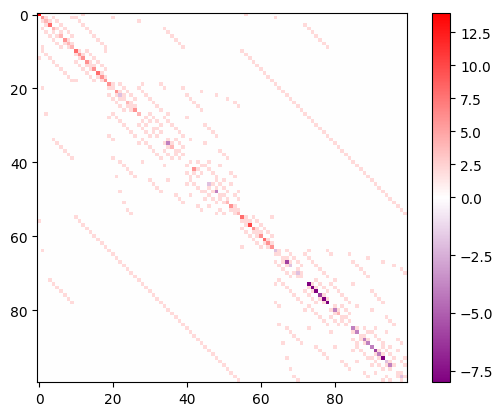

In [262]:
csrH = H.tocsr()

def sparsePlot(A):
    norm = TwoSlopeNorm(vcenter=0)
    plt.imshow(A,cmap=colors.LinearSegmentedColormap.from_list("", ["purple","white","red"]),interpolation=None,norm=norm)
    plt.colorbar()

sparsePlot(csrH[0:100,0:100].toarray())

### Exact Diagonalization

In [263]:
numEnergies = 100

energies, states = sparse.linalg.eigs(H.asfptype(), k=numEnergies, which='SR')

energies = np.real(energies)
states = np.real(states)

print(energies[0])

-41.359467


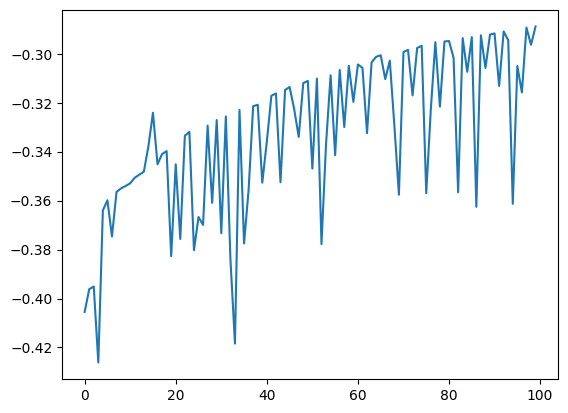

In [264]:
def spinCorrelation(states,n):
    spin_corr = 0
    for i in range(0,len(states)):
        spin_corr += (states[i][n]**2)*csrH[i,i]

    numNeighbors = 0
    for i in range(0,len(J)):
        for j in range(0,len(J[0])):
            numNeighbors += J[i][j]
    spin_corr /= (numNeighbors/2)
    return spin_corr

spinCorrelations = []

for i in range(0,numEnergies):
    spinCorrelations.append(spinCorrelation(states,i))

plt.plot(np.array(spinCorrelations))

### Compare Results to NetKet

In [265]:
lattice = nk.graph.Grid(extent=[4,5], pbc=True)
hilbertSpace = nk.hilbert.Spin(s=0.5, total_sz=0.5*(n-2*n0), N=n)
hamiltonian = nk.operator.Heisenberg(hilbert=hilbertSpace, graph=lattice)

netketH = hamiltonian.to_sparse()

evals = nk.exact.lanczos_ed(hamiltonian)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)

IndexError: list index out of range

### Visualize Lattices

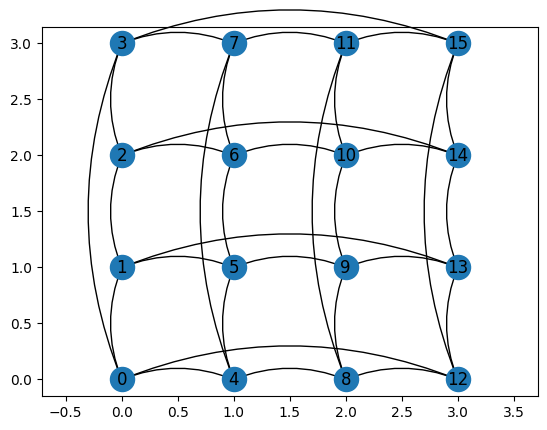

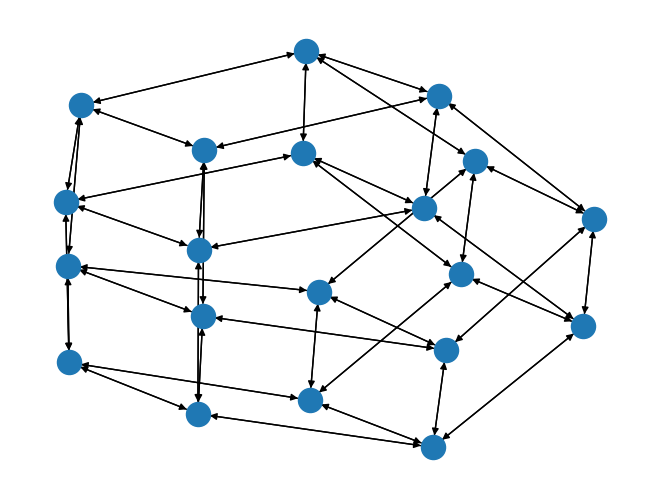

In [ ]:
lattice.draw()
plt.show()

import networkx as nx 
G = nx.DiGraph() 

for i in range(np.shape(J)[0]): 
 for j in range(np.shape(J)[0]): 
   if J[i][j] != 0: 
      G.add_edge(i,j) 
nx.draw(G) 
plt.show()